In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tqdm import tqdm
import os
import shutil

import networkx as nx

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)

from molvs import standardize_smiles

import pubchempy 

RDKit WARNING: [12:49:08] Enabling RDKit 2019.09.2 jupyter extensions


# Repurposed small-molecule drugs for COVID

The following list is from the recent article by Liu et al [1]. 

![](images/covid_drugs_from_article.png)

[1. C. Liu, Q. Zhou, Y. Li, L. V. Garner, S. P. Watkins, L. J. Carter, J. Smoot, A. C. Gregg, A. D. Daniels, S. Jervey, D. Albaiu, Research and Development on Therapeutic Agents and Vaccines for COVID-19 and Related Human Coronavirus Diseases. ACS Cent. Sci. (2020)](https://doi.org/10.1021/acscentsci.0c00272)

In [2]:
df = pd.read_csv("covid_drugname_cas.csv", delimiter="\t")
df

,name,cas_id
0,Baricitinib,1187594-09-7
1,Lopinavir,192725-17-0
2,Ritonavir,155213-67-5
3,Darunavir,206361-99-1
4,Favipiravir,259793-96-9
5,Remdesivir,1809249-37-3
6,Ribavirin,36791-04-5
7,Galidesivir,249503-25-1
8,Arbidol,131707-23-8
9,Chloroquine,1954-05-07


In [3]:
def name2smiles(name):
    """
    Uses pubchempy to fetch the smiles of a molecule, given its name. 
    """
    pubchem_compounds = pubchempy.get_compounds(name, "name")
    try:
        return pubchem_compounds[0].isomeric_smiles
    except:
        return None

In [4]:
df["smiles"] = df["name"].map(name2smiles)

In [5]:
df.to_csv("mols_w_smiles.csv")
#df = pd.read_csv("mols_w_smiles.csv", index_col=0)

In [6]:
PandasTools.AddMoleculeColumnToFrame(df, smilesCol="smiles", molCol="rdmol")

In [7]:
df.rdmol.map(rdDepictor.Compute2DCoords)
img = Draw.MolsToGridImage(df.rdmol,molsPerRow=3,subImgSize=(400,400),legends=list(df.name))

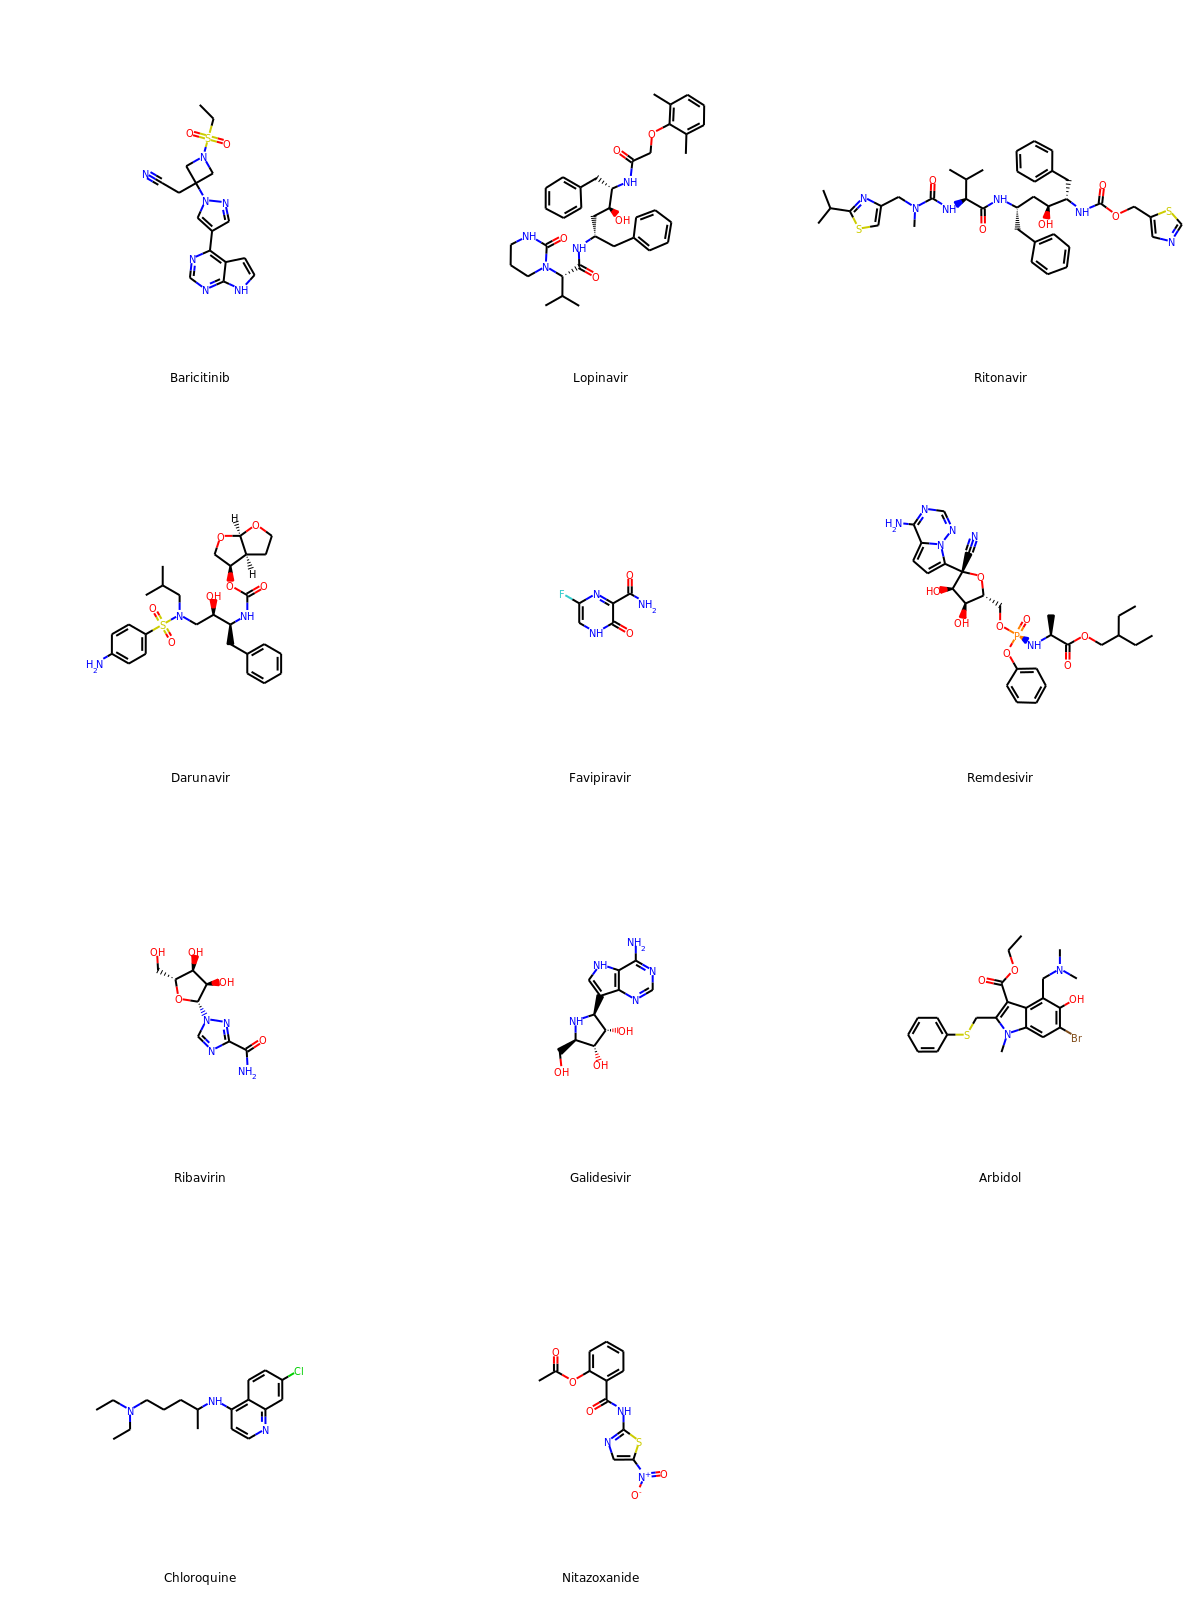

In [8]:
img

In [13]:
img.save("images/liu_article_antivirals.png")


# 3D structure generation

- Some of these compounds have quite many rotatable bonds..

In [14]:
df["nrotbonds"] = df.rdmol.map(rdMolDescriptors.CalcNumRotatableBonds)
df[["name", "nrotbonds"]]

,name,nrotbonds
0,Baricitinib,5
1,Lopinavir,15
2,Ritonavir,17
3,Darunavir,11
4,Favipiravir,1
5,Remdesivir,13
6,Ribavirin,3
7,Galidesivir,2
8,Arbidol,7
9,Chloroquine,8


# Similarity searches